## Git clone을 통한 tflite 환경 조성
 - tensorflow-yolov4-tflite를 이용해 darknet 모델을 export

In [ ]:
!git clone https://github.com/theAIGuysCode/tensorflow-yolov4-tflite

Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 912, done.
remote: Total 912 (delta 0), reused 0 (delta 0), pack-reused 912
Receiving objects: 100% (912/912), 211.46 MiB | 23.78 MiB/s, done.
Resolving deltas: 100% (441/441), done.


In [ ]:
pip install -r requirements.txt

In [ ]:
%cd /content/drive/MyDrive/tensorflow-yolov4-tflite-master

/content/drive/MyDrive/tensorflow-yolov4-tflite-master


## 최종 weights를 이용해 모델 저장
 - 저장 전에 config 파일의 classes 경로를 obj.names로 변경

In [ ]:
!python save_model.py --weights /content/drive/MyDrive/yolov4_best_final.weights --output /content/drive/MyDrive/yolov4/face_recognition-608 --input_size 608 --model yolov4

2021-07-01 05:04:21.865860: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-01 05:04:25.688295: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-01 05:04:25.786726: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-01 05:04:25.786793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5508f2a0defd): /proc/driver/nvidia/version does not exist
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
____________________________________

## Export한 모델이 잘 작동하는지 test

In [1]:
%cd /content/drive/MyDrive/tensorflow-yolov4-tflite-master

/content/drive/MyDrive/tensorflow-yolov4-tflite-master


In [2]:
import tensorflow as tf
# 2 ~ 6
import core.utils as utils
from core.yolov4 import filter_boxes

from PIL import Image
import cv2
import numpy as np
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

In [3]:
# 필요 변수 선언
IMG_SIZE = 608
MODEL_PATH = '/content/drive/MyDrive/yolov4/face_recognition-608'  #변환한 saved model 경로
OUTPUT_PATH = './predict_result'  #변환 결과 이미지 저장할 경로
if not os.path.isdir(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)
    
# NMS 사용할 Threshold
IOU_THRESH = 0.5 
CONFIDENCE_SCORE_THRESH = 0.5

In [4]:
# 추론할 이미지 로딩
IMAGE_PATH = '/content/drive/MyDrive/yolov4/celeb_test_pic/DD.jpg'

ori_image = cv2.imread(IMAGE_PATH)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

# 전처리 - resize, 정규화, batch 더미축 추가
image_data = cv2.resize(ori_image, (IMG_SIZE, IMG_SIZE))
image_data = image_data / 255.
image_data = image_data.astype(np.float32)
print(image_data.shape)
image_data = image_data[np.newaxis, ...]
print(image_data.shape)

(608, 608, 3)
(1, 608, 608, 3)


In [5]:
# 모델 Loading
model = tf.keras.models.load_model(MODEL_PATH)

In [6]:
input_tensor = tf.convert_to_tensor(image_data)

In [7]:
# 추론
pred = model.predict(input_tensor)

In [8]:
print(pred.shape)

(1, 6, 8)


In [9]:
boxes = pred[:, :, 0:4]  #bounding box에 대한 예측 결과
pred_conf = pred[:, :, 4:]  #class별 예측 확률
print(boxes.shape, pred_conf.shape)

(1, 6, 4) (1, 6, 4)


In [10]:
boxes

array([[[0.21424   , 0.48577395, 0.9128428 , 0.95287544],
        [0.21749485, 0.48888075, 0.908708  , 0.95221853],
        [0.22147329, 0.49217084, 0.95861775, 0.9535113 ],
        [0.22361733, 0.50023705, 0.9558438 , 0.9418291 ],
        [0.25493318, 0.5113298 , 0.92896   , 0.97836405],
        [0.2515099 , 0.5380349 , 0.9286242 , 0.94712085]]], dtype=float32)

In [11]:
pred_conf[-1]

array([[4.5580892e-03, 6.5178475e-03, 4.0609387e-04, 8.5677809e-01],
       [5.5970489e-03, 6.0668811e-03, 8.0203236e-04, 9.0527433e-01],
       [6.0972939e-03, 1.1490458e-02, 4.7515129e-04, 9.2490768e-01],
       [6.8906453e-03, 9.7062821e-03, 7.2740304e-04, 9.5475781e-01],
       [1.3637623e-03, 5.4820636e-03, 1.4831669e-04, 4.0849388e-01],
       [2.2272735e-03, 6.8037272e-03, 2.3053747e-04, 5.3271705e-01]],
      dtype=float32)

In [12]:
# Non Maximum Suppression
boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
                                        boxes = tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
                                        scores = tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
                                        max_output_size_per_class=50,
                                        max_total_size=50,
                                        iou_threshold=IOU_THRESH,
                                        score_threshold=CONFIDENCE_SCORE_THRESH
                                        )

In [13]:
print(classes)

tf.Tensor(
[[3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]], shape=(1, 50), dtype=float32)


In [14]:
valid_detections, boxes.shape

(<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 TensorShape([1, 50, 4]))

In [15]:
boxes

<tf.Tensor: shape=(1, 50, 4), dtype=float32, numpy=
array([[[0.22361733, 0.50023705, 0.9558438 , 0.9418291 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        ,

In [16]:
pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
result_image = utils.draw_bbox(ori_image, pred_bbox)

In [17]:
classes.numpy()[0][0]

3.0

In [23]:
type(result_image), result_image.dtype

(numpy.ndarray, dtype('uint8'))

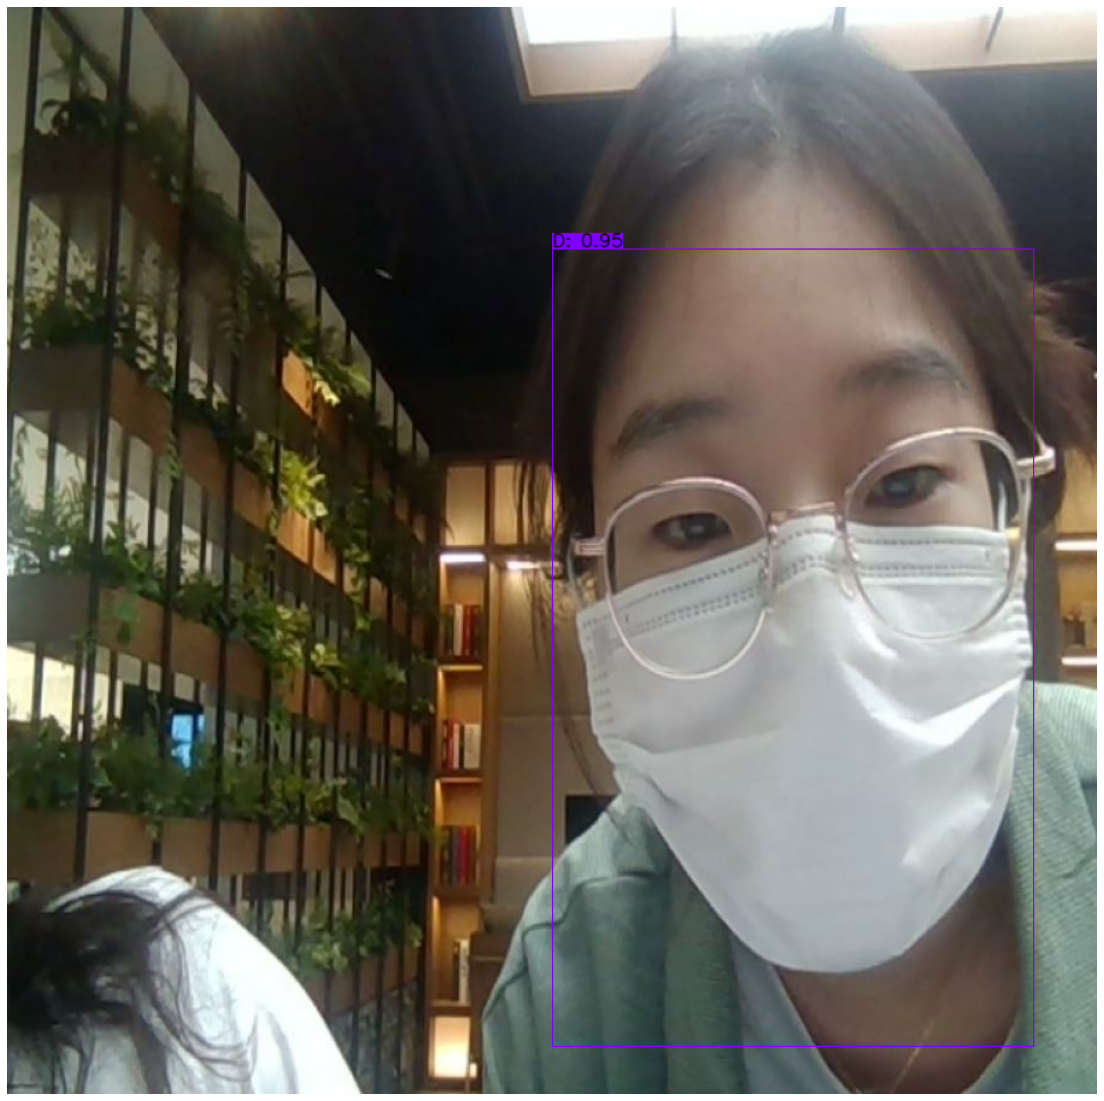

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(result_image)
plt.axis('off')
plt.show()